Here we try to find an optimal rotation to align sentiment as much as possible with a single dimension of the data representation. We use the first 3 principal components, so this is a 3d problem. We describe a rotation as a list of 3 Euler angles.


Later we may try rotating in high dimensions (either the full-rank PCA or the original semantic embeddings), but that is more complicated and will be harder to optimize (the degrees of freedom for higher dimensional rotations scale as n(n-1)/2.)

In [106]:
import pandas as pd
import plotly.express as px

df_3d = pd.read_csv('df_3d.csv', index_col=0).reset_index(drop=True)

fig = px.scatter_3d(df_3d, x = 'x', y='y', z = 'z', color='color', symbol='category', width=1200, height=1200)
fig.layout.scene.aspectratio = {'x':1, 'y':1, 'z':1}
fig.show()

In [107]:
# https://en.wikipedia.org/wiki/Rotation_matrix

import numpy as np
from math import sin, cos, pi

def get_R(a, b, c):
    return np.array([
    	[cos(a)*cos(b), cos(a) * sin(b) * sin(c) - sin(a) * cos(c), cos(a) * sin(b) * cos(c) + sin(a) * sin(c)],
    	[sin(a) * cos(b), sin(a) * sin(b) * sin(c) * cos(a) * cos(c), sin(a) * sin(b) * cos(c) - cos(a) * sin(c)],
    	[-sin(b), cos(b) * sin(c), cos(b) * cos(c)]
    ])

def get_R_check(a, b, c):
	Ra = np.array(
		[ [cos(a), -sin(a), 0],
		  [sin(a),  cos(a), 0],
		  [0,       0,      1] ])

	Rb = np.array(
		[ [ cos(b), 0,   sin(b)],
		  [ 0,      1,   0],
		  [-sin(b), 0,   cos(b)] ])

	Rc = np.array(
		[ [1,  0,       0],
		  [0,  cos(c), -sin(c)],
		  [0,  sin(c),  cos(c)] ])

	return np.dot(np.dot(Ra, Rb), Rc)


get_R(0,0,0) # No rotation gives the identity matrix

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  0.],
       [-0.,  0.,  1.]])

In [108]:
x0 = np.random.uniform(low=-pi, high=pi, size=3)
x0

array([2.28920799, 1.99006051, 0.09810987])

In [109]:
get_R(*x0)

array([[ 0.26794145, -0.80811912, -0.52454825],
       [-0.30647742, -0.04412032,  0.74881116],
       [-0.91338873, -0.03987536, -0.40513083]])

In [110]:
get_R_check(*x0)

array([[ 0.26794145, -0.80811912, -0.52454825],
       [-0.30647742, -0.5876678 ,  0.74881116],
       [-0.91338873, -0.03987536, -0.40513083]])

In [111]:
df_3d

,x,y,z,label,color,category,marker
0,-0.193805,-0.132629,0.109469,0.0,#0000FF,amazon,o
1,-0.158579,-0.020862,-0.119280,1.0,#FF0000,amazon,o
2,-0.131406,-0.021342,-0.133600,1.0,#FF0000,amazon,o
3,-0.389379,-0.274278,0.045716,0.0,#0000FF,amazon,o
4,-0.297461,-0.121682,-0.269128,1.0,#FF0000,amazon,o
...,...,...,...,...,...,...,...
2744,0.084281,0.184778,0.310639,0.0,#0000FF,yelp,s
2745,0.127119,0.048866,0.160198,0.0,#0000FF,yelp,s
2746,0.179452,0.177626,0.047402,0.0,#0000FF,yelp,s
2747,0.060480,0.164798,0.296681,0.0,#0000FF,yelp,s


In [112]:
df_3d[['x', 'y', 'z']].to_numpy()

array([[-0.19380463, -0.13262922,  0.10946888],
       [-0.15857927, -0.0208624 , -0.11927986],
       [-0.13140555, -0.02134232, -0.13359986],
       ...,
       [ 0.17945212,  0.17762615,  0.04740206],
       [ 0.06048018,  0.16479818,  0.29668095],
       [-0.04834002,  0.10430248, -0.7667494 ]])

In [113]:
R = get_R(*x0)
rotated = np.dot(df_3d[['x', 'y', 'z']].to_numpy(), R)
rotated

array([[-0.11126807,  0.15810376, -0.04200357],
       [ 0.07285278,  0.13382772,  0.11588443],
       [ 0.09336055,  0.11246031,  0.1070726 ],
       ...,
       [-0.04965225, -0.15474578,  0.01967311],
       [-0.30528681, -0.0679764 , -0.02851665],
       [ 0.65542161,  0.06503704,  0.41409336]])

In [114]:
rotated[:,0]

array([-0.11126807,  0.07285278,  0.09336055, ..., -0.04965225,
       -0.30528681,  0.65542161])

In [115]:
def rotate_euler(M, x):
    R = get_R(*x)
    return np.dot(M, R)

def rotate_align(x):
    # X is a vector of 3 Euler angles each ranging between -pi and +pi.
    # This vector will be used to compute a rotation matrix, which will in turn rotate the 3D PCA dataset.
    # The score to maximize the correlation of the 3rd PC with the sentiment model score
    from scipy.stats import pearsonr
    rotated = rotate_euler(df_3d[['x', 'y', 'z']].to_numpy(), x)
    labels = df_3d['label'].tolist()
    labels[-1] = 1  # consider the coefficient vector to be positive!
    return -1 * pearsonr(rotated[:,2], labels)[0]

In [116]:
from scipy.optimize import minimize
res = minimize(rotate_align, x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

print(res.x)

Optimization terminated successfully.
         Current function value: -0.711757
         Iterations: 101
         Function evaluations: 199
[2.18314429 2.98107232 0.08782093]


In [117]:
rotated = pd.DataFrame(rotate_euler(df_3d[['x', 'y', 'z']].to_numpy(), res.x), columns=['x', 'y', 'z'])

for col in ['label', 'color', 'category', 'marker']:
    rotated[col] = df_3d[col]

rotated

,x,y,z,label,color,category,marker
0,-0.020326,0.150934,-0.127785,0.0,#0000FF,amazon,o
1,-0.054061,0.141008,0.116654,1.0,#FF0000,amazon,o
2,-0.035966,0.119881,0.130112,1.0,#FF0000,amazon,o
3,-0.006685,0.318382,-0.086829,0.0,#0000FF,amazon,o
4,-0.027472,0.268972,0.248530,1.0,#FF0000,amazon,o
...,...,...,...,...,...,...,...
2744,-0.151089,-0.097490,-0.273738,0.0,#0000FF,yelp,s
2745,0.007050,-0.118836,-0.151209,0.0,#0000FF,yelp,s
2746,-0.049238,-0.152997,-0.018058,0.0,#0000FF,yelp,s
2747,-0.146223,-0.076557,-0.263153,0.0,#0000FF,yelp,s


<Axes: xlabel='x', ylabel='y'>

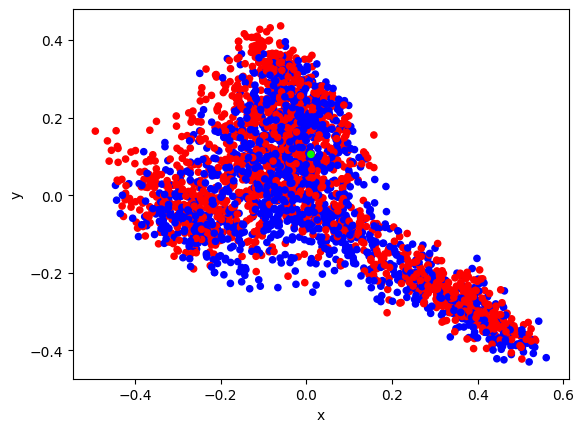

In [134]:
rotated.plot.scatter(x='x', y='y', c=df_3d['color'].values)

In [118]:
fig = px.scatter_3d(rotated, x = 'x', y='y', z = 'z', color='color', symbol='category', width=1200, height=1200)
fig.layout.scene.aspectratio = {'x':1, 'y':1, 'z':1}
fig.show()

In [124]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.from_euler.html

from scipy.spatial.transform import Rotation as R

r = R.from_euler('zyx', [90, 45, 30], degrees=True)

In [125]:
r.as_matrix()

array([[ 1.11022302e-16, -7.07106781e-01,  7.07106781e-01],
       [ 8.66025404e-01, -3.53553391e-01, -3.53553391e-01],
       [ 5.00000000e-01,  6.12372436e-01,  6.12372436e-01]])

In [126]:
?R.from_euler

Docstring:
Rotation.from_euler(type cls, seq, angles, degrees=False)
Initialize from Euler angles.

        Rotations in 3-D can be represented by a sequence of 3
        rotations around a sequence of axes. In theory, any three axes spanning
        the 3-D Euclidean space are enough. In practice, the axes of rotation are
        chosen to be the basis vectors.

        The three rotations can either be in a global frame of reference
        (extrinsic) or in a body centred frame of reference (intrinsic), which
        is attached to, and moves with, the object under rotation [1]_.

        Parameters
        ----------
        seq : string
            Specifies sequence of axes for rotations. Up to 3 characters
            belonging to the set {'X', 'Y', 'Z'} for intrinsic rotations, or
            {'x', 'y', 'z'} for extrinsic rotations. Extrinsic and intrinsic
            rotations cannot be mixed in one function call.
        angles : float or array_like, shape (N,) or (N, [1 or 2

In [132]:
n = 768
n * (n - 1)/2

294528.0